In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import helpers.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=False))

In [5]:
import helpers.utils as utls
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, shuffle=True,
 collate_fn=utls.collate_fn)
images,targets = next(iter(data_loader))

img = images[0]
trgt = targets[0]

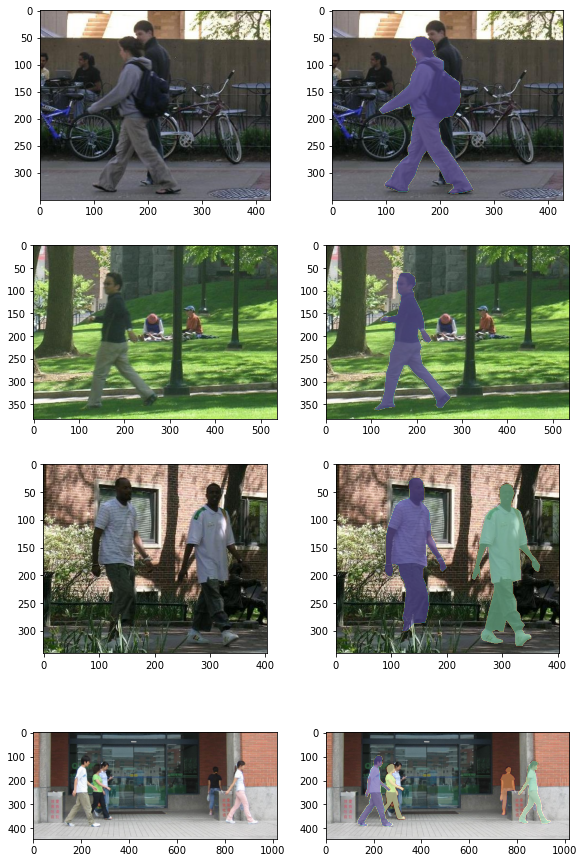

In [6]:
import torchvision

def display_masks(list_img, list_trgt):
    trans_img = torchvision.transforms.ToPILImage()

    # set up the Axes objects
    fig, ax = plt.subplots(nrows=len(list_img), ncols =2 ,figsize=(9.6, 16))
    for j, img in enumerate(list_img):
    # plot using 'continuous' colormap
        im = ax[j,0].imshow(trans_img(img))
        im = ax[j,1].imshow(trans_img(img))

        trgt = list_trgt[j]
        masks = torch.zeros_like(img[0])
        for i,mask in enumerate(trgt["masks"]):
            if len(mask.size())>2:
                mask=mask[0]
            masks[mask > 0.5] += 50 * (i+1)


        im = ax[j,1].imshow(trans_img(masks),alpha = 0.6 * masks.type(torch.bool).type(torch.float).numpy(), cmap=plt.cm.Spectral)


    plt.show()
    
display_masks(images, targets)

In [7]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
from helpers.engine import train_one_epoch, evaluate


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utls.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utls.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


/Users/erfan/opt/anaconda3/envs/CS231n_env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0]  [ 0/60]  eta: 0:26:26  lr: 0.000090  loss: 4.1103 (4.1103)  loss_classifier: 0.7920 (0.7920)  loss_box_reg: 0.3791 (0.3791)  loss_mask: 2.9280 (2.9280)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 26.4458  data: 0.0640
Epoch: [0]  [10/60]  eta: 0:20:44  lr: 0.000936  loss: 1.6853 (2.2498)  loss_classifier: 0.5092 (0.4826)  loss_box_reg: 0.2898 (0.2690)  loss_mask: 1.0128 (1.4753)  loss_objectness: 0.0199 (0.0187)  loss_rpn_box_reg: 0.0026 (0.0043)  time: 24.8816  data: 0.0871
Epoch: [0]  [20/60]  eta: 0:16:23  lr: 0.001783  loss: 1.0239 (1.5504)  loss_classifier: 0.2266 (0.3560)  loss_box_reg: 0.2597 (0.2661)  loss_mask: 0.3472 (0.8954)  loss_objectness: 0.0217 (0.0263)  loss_rpn_box_reg: 0.0052 (0.0066)  time: 24.5072  data: 0.0843
Epoch: [0]  [30/60]  eta: 0:12:07  lr: 0.002629  loss: 0.5989 (1.2470)  loss_classifier: 0.1269 (0.2767)  loss_box_reg: 0.2307 (0.2684)  loss_mask: 0.2158 (0.6722)  loss_objectness: 0.0202 (0.0220)  loss_rpn_box_re

Epoch: [2]  [ 0/60]  eta: 0:20:00  lr: 0.005000  loss: 0.2636 (0.2636)  loss_classifier: 0.0258 (0.0258)  loss_box_reg: 0.0787 (0.0787)  loss_mask: 0.1526 (0.1526)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 20.0135  data: 0.0306
Epoch: [2]  [10/60]  eta: 0:18:46  lr: 0.005000  loss: 0.2264 (0.2231)  loss_classifier: 0.0319 (0.0331)  loss_box_reg: 0.0632 (0.0582)  loss_mask: 0.1225 (0.1251)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0054 (0.0057)  time: 22.5291  data: 0.0776
Epoch: [2]  [20/60]  eta: 0:14:30  lr: 0.005000  loss: 0.2146 (0.2289)  loss_classifier: 0.0306 (0.0310)  loss_box_reg: 0.0528 (0.0624)  loss_mask: 0.1225 (0.1294)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0049 (0.0051)  time: 21.8448  data: 0.0810
Epoch: [2]  [30/60]  eta: 0:10:49  lr: 0.005000  loss: 0.2093 (0.2252)  loss_classifier: 0.0278 (0.0304)  loss_box_reg: 0.0528 (0.0612)  loss_mask: 0.1212 (0.1281)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_re

Epoch: [4]  [ 0/60]  eta: 0:18:39  lr: 0.000500  loss: 0.1630 (0.1630)  loss_classifier: 0.0186 (0.0186)  loss_box_reg: 0.0286 (0.0286)  loss_mask: 0.1131 (0.1131)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 18.6518  data: 0.0376
Epoch: [4]  [10/60]  eta: 0:19:05  lr: 0.000500  loss: 0.1813 (0.1888)  loss_classifier: 0.0243 (0.0287)  loss_box_reg: 0.0322 (0.0409)  loss_mask: 0.1131 (0.1153)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0028 (0.0033)  time: 22.9057  data: 0.0646
Epoch: [4]  [20/60]  eta: 0:15:07  lr: 0.000500  loss: 0.1813 (0.1964)  loss_classifier: 0.0267 (0.0295)  loss_box_reg: 0.0365 (0.0452)  loss_mask: 0.1151 (0.1179)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0026 (0.0029)  time: 22.8904  data: 0.0717
Epoch: [4]  [30/60]  eta: 0:11:26  lr: 0.000500  loss: 0.1830 (0.1968)  loss_classifier: 0.0267 (0.0288)  loss_box_reg: 0.0426 (0.0469)  loss_mask: 0.1138 (0.1170)  loss_objectness: 0.0006 (0.0008)  loss_rpn_box_re

Epoch: [6]  [ 0/60]  eta: 19:24:52  lr: 0.000050  loss: 0.1854 (0.1854)  loss_classifier: 0.0253 (0.0253)  loss_box_reg: 0.0449 (0.0449)  loss_mask: 0.1142 (0.1142)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 1164.8826  data: 0.5317
Epoch: [6]  [10/60]  eta: 4:25:31  lr: 0.000050  loss: 0.1803 (0.1832)  loss_classifier: 0.0264 (0.0267)  loss_box_reg: 0.0354 (0.0372)  loss_mask: 0.1112 (0.1169)  loss_objectness: 0.0003 (0.0004)  loss_rpn_box_reg: 0.0015 (0.0020)  time: 318.6382  data: 0.8494
Epoch: [6]  [20/60]  eta: 3:15:50  lr: 0.000050  loss: 0.1803 (0.1893)  loss_classifier: 0.0264 (0.0287)  loss_box_reg: 0.0395 (0.0411)  loss_mask: 0.1069 (0.1163)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0023 (0.0026)  time: 250.1996  data: 0.8918
Epoch: [6]  [30/60]  eta: 2:13:16  lr: 0.000050  loss: 0.1727 (0.1810)  loss_classifier: 0.0216 (0.0254)  loss_box_reg: 0.0367 (0.0386)  loss_mask: 0.1073 (0.1142)  loss_objectness: 0.0002 (0.0005)  loss_rpn_b

Epoch: [8]  [ 0/60]  eta: 0:18:29  lr: 0.000050  loss: 0.1391 (0.1391)  loss_classifier: 0.0119 (0.0119)  loss_box_reg: 0.0252 (0.0252)  loss_mask: 0.1005 (0.1005)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 18.4913  data: 0.0273
Epoch: [8]  [10/60]  eta: 0:16:43  lr: 0.000050  loss: 0.1434 (0.1660)  loss_classifier: 0.0196 (0.0255)  loss_box_reg: 0.0314 (0.0383)  loss_mask: 0.0916 (0.0977)  loss_objectness: 0.0003 (0.0014)  loss_rpn_box_reg: 0.0022 (0.0032)  time: 20.0686  data: 0.0642
Epoch: [8]  [20/60]  eta: 0:13:56  lr: 0.000050  loss: 0.1675 (0.1774)  loss_classifier: 0.0227 (0.0272)  loss_box_reg: 0.0314 (0.0396)  loss_mask: 0.1025 (0.1066)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0018 (0.0028)  time: 21.0334  data: 0.0734
Epoch: [8]  [30/60]  eta: 0:10:51  lr: 0.000050  loss: 0.1688 (0.1733)  loss_classifier: 0.0212 (0.0245)  loss_box_reg: 0.0297 (0.0368)  loss_mask: 0.1073 (0.1083)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_re

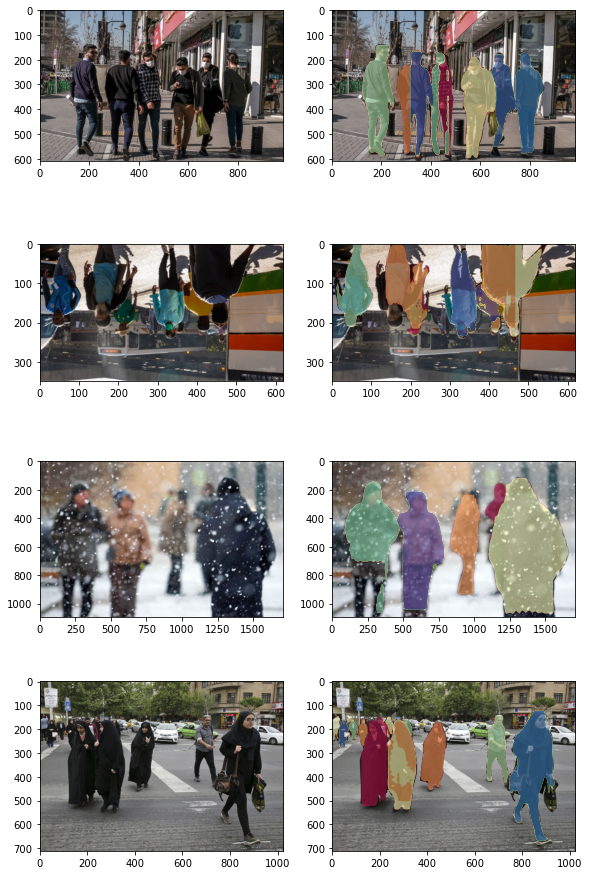

In [9]:
test_set = []
test_transform = get_transform(train=False)
num_test = 4
for i in range(num_test):
    test_set.append(Image.open(f'samp{i+1}.png'))
    test_set[i], tar = test_transform(test_set[i],{})



tar = model(test_set)
display_masks(test_set, tar)
